In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import cx_Oracle
from config import oracle_wfm_key
from config import oracle_ods_key
from sqlalchemy.types import String
from tqdm import tqdm
import datetime
from datetime import datetime
import datetime as dt
import time
import databases as db
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current date
current_date = datetime.today()
# Set service level goal
service_level_goal = 0.65
# load the dataset
ods = db.oracle('cco_wfm',oracle_wfm_key)
query = f'''SELECT * FROM "CCO_WFM"."Staffing_Analysis_Regressors"'''
df = pd.read_sql(query, ods)

In [3]:
df = df.loc[(df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]

In [4]:
# Group by 'workgroup_set', 'call_date', and 'service_name' and sum 'paid', 'phone', 'absence', 'exceptions', and 'offphone'
grouped_df = df.groupby(['workgroup_set', 'call_date', 'service_name'])[['paid', 'phone', 'absence', 'exceptions', 'offphone']].sum().reset_index()

# Create df_unique by dropping duplicates from df excluding 'paid', 'phone', 'absence', 'exceptions', and 'offphone'
df_unique = df.drop(columns=['paid', 'phone', 'absence', 'exceptions', 'offphone']).drop_duplicates(subset=['workgroup_set', 'service_name', 'call_date'])

# Merge the summed values back to the unique dataframe
df_unique = df_unique.merge(grouped_df, on=['workgroup_set', 'call_date', 'service_name'], how='left')

df_unique.to_csv('data_unique.csv')

df_unique.head()

,workgroup_set,service_name,call_date,offered_calls,in_sl,inbound_handle,queuetime,abandoned_calls,transfers,sl%,abandon%,asa,aht,occupancy,attrition,paid,phone,absence,exceptions,offphone
0,Other,Agent_Outbound,2021-08-01,0,0,0,1749,0,43,0.000000,0.000000,69.876829,0.000,0.391438,3.0,13169.85,7832.32,1379.616594,2403.32,5445.75
1,Other,Bend_CustCare_Dispatch_TechSpt_Outbound,2021-08-01,0,0,0,0,0,2,0.000000,0.000000,0.000000,0.000,0.391438,3.0,13169.85,7832.32,1379.616594,2403.32,5445.75
2,Other,Bend_Spanish_Queue,2021-08-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000,0.391438,3.0,13169.85,7832.32,1379.616594,2403.32,5445.75
3,Other,Cable_Business_Billing,2021-08-01,600,398,288561,76394,28,180,0.663333,0.046667,127.323333,480.935,0.391438,3.0,13169.85,7832.32,1379.616594,2403.32,5445.75
4,Other,Cable_Business_Outbound,2021-08-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000,0.391438,3.0,13169.85,7832.32,1379.616594,2403.32,5445.75


In [5]:
df_unique['workgroup_set'].unique()

array(['Other', 'Repair_ABS', 'Financial_Services_Residential',
       'Repair_Cable_Business', 'Repair_Cable_Residential', 'APC',
       'Commercial_Billing', 'Repair_Wireline_Residential',
       'Wireline_Consumer_Sales', 'Cable_Seniors_CCO_Support',
       'Wireline_Seniors_CCO_Support', 'COAST', 'TDS_Corporate',
       'Repair_Seniors', 'Cable_Consumer_Specialist', 'Repair_RPC',
       'FST_Dispatch', 'Cable_Consumer_Sales',
       'Wireline_Consumer_Specialist', 'Repair_Continuum',
       'Continuum_Sales', 'Repair_Support-Chat',
       'Financial_Services_Business', 'Repair_Wireline_Business'],
      dtype=object)

In [6]:
# List of workgroup_set categories to drop
categories_to_drop = ['Repair_ABS', 'Other', 'FST_Dispatch', 'Repair_RPC',
                      'COAST', 'Repair_Continuum', 'TDS_Corporate', 
                      'Continuum_Sales', 'APC', 'Commercial_Billing', 
                      'Repair_Support-Chat']

# Drop rows where 'workgroup_set' matches the categories_to_drop
df_unique = df_unique[~df_unique['workgroup_set'].isin(categories_to_drop)]

In [7]:
# Group the sum of offered_calls by call_date
offered_calls = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['offered_calls'].sum().reset_index()

In [8]:
# Group the sum of inbound_handle by call_date
avg_handle_time = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['inbound_handle'].sum().reset_index()

# Calculate average handle time by dividing grouped offered_calls by the sum of inbound_handle
avg_handle_time['avg_handle_time'] = avg_handle_time['inbound_handle'] / df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['offered_calls'].sum().values

# Drop extra columns
avg_handle_time.drop(columns=['inbound_handle'], inplace=True)

In [9]:
# Group offered_calls and in_sl by call_date
service_level_percent = df_unique.groupby(['workgroup_set', 'call_date', 'service_name']).agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent['service_level_percent'] = service_level_percent['in_sl'] / service_level_percent['offered_calls']

# Drop extra columns
service_level_percent.drop(columns=['offered_calls', 'in_sl'], inplace=True)

In [10]:
# Group offered_calls and in_sl by call_date
service_level_percent_to_goal = df_unique.groupby(['workgroup_set', 'call_date', 'service_name']).agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent'] = service_level_percent_to_goal['in_sl'] / service_level_percent_to_goal['offered_calls']

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent_to_goal'] = service_level_percent_to_goal['service_level_percent'] / service_level_goal

# Drop extra columns
service_level_percent_to_goal.drop(columns=['offered_calls', 'in_sl','service_level_percent'], inplace=True)

In [11]:
# Group the sum of offered_calls and abandoned_calls by call_date
abandon_percent = df_unique.groupby(['workgroup_set', 'call_date', 'service_name']).agg({'offered_calls': 'sum', 'abandoned_calls': 'sum'}).reset_index()

# Calculate abandon_percent by dividing abandoned_calls by offered_calls
abandon_percent['abandon_percent'] = abandon_percent['abandoned_calls'] / abandon_percent['offered_calls']

# Drop extra columns
abandon_percent.drop(columns=['offered_calls', 'abandoned_calls'], inplace=True)

In [12]:
# Group the sum of offered_calls and queuetime by call_date
avg_speed_of_answer = df_unique.groupby(['workgroup_set', 'call_date', 'service_name']).agg({'offered_calls': 'sum', 'queuetime': 'sum'}).reset_index()

# Calculate avg_speed_of_answer by dividing queuetime by offered_calls
avg_speed_of_answer['avg_speed_of_answer'] = avg_speed_of_answer['queuetime'] / avg_speed_of_answer['offered_calls']

# Drop extra columns
avg_speed_of_answer.drop(columns=['offered_calls', 'queuetime'], inplace=True)

In [13]:
# Calculate phone sum by workgroup set, service name, and call_date level
grouped_df = df_unique.groupby(['workgroup_set','call_date', 'service_name'])['occupancy','phone'].mean().reset_index()

# Calculate updated occupancy by multiplying occupancy with corresponding phone time and summing them up for each 'workgroup_set'
grouped_df['updated_phone'] = grouped_df['occupancy'] * grouped_df['phone']
occupancy = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['updated_phone'].sum().reset_index()
phone = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['phone'].sum().reset_index()

# Divide the sum of 'updated_occupancy' by the total 'phone' to get the updated occupancy
occupancy['occupancy'] = occupancy['updated_phone'] / phone['phone']

# Keep only the 'call_date' and 'updated_occupancy' columns
occupancy = occupancy[['workgroup_set', 'call_date', 'service_name', 'occupancy']]


C:\Users\usrocu\AppData\Local\Temp\ipykernel_15668\4059702103.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df_unique.groupby(['workgroup_set','call_date', 'service_name'])['occupancy','phone'].mean().reset_index()


In [14]:
# Group the maximum of attrition by workgroup_set and call_date
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['attrition'].max().reset_index()

# Sum the totals by call_date
attrition = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['attrition'].sum().reset_index()

In [15]:
# seniors = df.loc[((df['workgroup_set'] == 'Cable_Seniors_CCO_Support') | (df['workgroup_set'] == 'Wireline_Seniors_CCO_Support')) & (df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]
# # Drop duplicates based on 'workgroup_set', 'call_date', and 'service_name'
# seniors_unique = seniors.drop_duplicates(subset=['workgroup_set', 'call_date', 'service_name'])
# # Group the sum of offered_calls by call_date
# senior_calls = seniors_unique.groupby('call_date')['offered_calls'].sum().reset_index()
# senior_calls.columns = ['call_date','senior_calls']

In [16]:
# Group the sum of paid hours by workgroup_set, call_date, and service_name
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['paid'].mean().reset_index()

# Sum the totals by workgroup_set, call_date, and service_name
paid = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['paid'].sum().reset_index()

In [17]:
# Group the sum of phone hours by workgroup_set, call_date, and service_name
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['phone'].mean().reset_index()

# Sum the totals by workgroup_set, call_date, and service_name
only_phone = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['phone'].sum().reset_index()

In [18]:
# Group the sum of absence hours by workgroup_set, call_date, and service_name
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['absence'].mean().reset_index()

# Sum the totals by workgroup_set, call_date, and service_name
absence = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['absence'].sum().reset_index()

In [19]:
# Group the sum of exception hours by workgroup_set, call_date, and service_name
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['exceptions'].mean().reset_index()

# Sum the totals by workgroup_set, call_date, and service_name
exceptions = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['exceptions'].sum().reset_index()

In [20]:
# Group the sum of offphone hours by workgroup_set, call_date, and service_name
grouped_df = df_unique.groupby(['workgroup_set', 'call_date', 'service_name'])['offphone'].mean().reset_index()

# Sum the totals by workgroup_set, call_date, and service_name
offphone = grouped_df.groupby(['workgroup_set', 'call_date', 'service_name'])['offphone'].sum().reset_index()

In [21]:
from functools import reduce

# Let's say dfs is a list of your dataframes
dfs = [offered_calls, avg_handle_time, service_level_percent, abandon_percent,
                            avg_speed_of_answer, occupancy, attrition, service_level_percent_to_goal,
                            paid, phone, absence, exceptions, offphone]

# Use reduce to merge all dataframes
df_final = reduce(lambda left,right: pd.merge(left,right,on=['workgroup_set', 'service_name', 'call_date']), dfs)


In [22]:
# Get unique months from 'call_date' column
unique_months = pd.to_datetime(df['call_date']).dt.to_period('M').unique()

# Calculate business days per month (including Saturdays)
business_days_per_month = []
for month in unique_months:
    start_date = month.to_timestamp()
    end_date = (month.to_timestamp() + pd.offsets.MonthEnd()).normalize()
    business_days = pd.bdate_range(start=start_date, end=end_date, freq='B').shape[0]
    business_days_per_month.append(business_days)

# Create a DataFrame with the results
business_days_df = pd.DataFrame({'call_date': unique_months, 'business_days': business_days_per_month})

In [23]:
# Read the DataFrame with monthly values
staffing = df_final
staffing['call_date'] = pd.to_datetime(staffing['call_date']).dt.to_period('M')
staffing = staffing.merge(business_days_df, on='call_date', how='left')


# Convert 'offered_calls' column to float
staffing['offered_calls'] = staffing['offered_calls'].astype(float)

# Calculate the Total Monthly Call Minutes
staffing['total_call_minutes'] = staffing['offered_calls'] * staffing['avg_handle_time']

# Calcualte the Staffing Requirements
shrinkage = 0.30
working_hours_per_day = 7.1667
staffing['staffing_requirements'] = ((((staffing['total_call_minutes']) / 3600) / staffing['occupancy']) * (1 + shrinkage)) / (staffing['business_days'] * working_hours_per_day)

In [24]:
staffing = staffing.replace([np.inf, -np.inf], np.nan)
staffing.fillna(0, inplace=True)
staffing.to_csv('regression_data.csv')
staffing.head()

,workgroup_set,call_date,service_name,offered_calls,avg_handle_time,service_level_percent,abandon_percent,avg_speed_of_answer,occupancy,attrition,service_level_percent_to_goal,paid,phone,absence,exceptions,offphone,business_days,total_call_minutes,staffing_requirements
0,Cable_Consumer_Sales,2021-08,Bend_Customer_Care_Prospect,1262.0,871.103803,0.688590,0.018225,36.252773,0.632041,1.0,1.059369,6000.9,3630.15,1241.699869,280.21,1863.03,22,1099333.0,3.983664
1,Cable_Consumer_Sales,2021-08,Bend_Customer_Care_Sales,2852.0,552.085905,0.681276,0.036466,73.044530,0.632041,1.0,1.048117,6000.9,3630.15,1241.699869,280.21,1863.03,22,1574549.0,5.705709
2,Cable_Consumer_Sales,2021-08,Bend_Customer_Care_Service,5229.0,414.586919,0.645056,0.102314,200.075158,0.632041,1.0,0.992394,6000.9,3630.15,1241.699869,280.21,1863.03,22,2167875.0,7.855750
3,Cable_Consumer_Sales,2021-08,Cable_Resi_Cust_Care,8279.0,397.877159,0.662036,0.090349,177.344244,0.632041,1.0,1.018518,6000.9,3630.15,1241.699869,280.21,1863.03,22,3294025.0,11.936591
4,Cable_Consumer_Sales,2021-08,Cable_Resi_Cust_Prospect,3082.0,801.792992,0.740428,0.017846,32.406230,0.632041,1.0,1.139120,6000.9,3630.15,1241.699869,280.21,1863.03,22,2471126.0,8.954643


In [25]:
# One-hot encoding of categorical variables
features = pd.get_dummies(staffing, columns=['workgroup_set', 'service_name'])

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Initiate Model

In [26]:
X = features.drop('staffing_requirements', axis=1)
y = features['staffing_requirements']

In [27]:
X['year'] = X['call_date'].apply(lambda x: x.year)
X['month'] = X['call_date'].apply(lambda x: x.month)
X['day'] = X['call_date'].apply(lambda x: x.day)
X = X.drop(columns='call_date')

In [28]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [29]:
# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the feature matrix X and target vector y
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# Make predictions using the updated model
predictions = model.predict(X)

# Print the predicted values
print(predictions)

[ 7.07738558e+13  7.05244600e+13  6.92892807e+13  7.17939837e+13
  7.44673234e+13  7.44101160e+13  4.72913300e+13  4.92169660e+13
  4.92169660e+13  6.90432608e+13  6.68750762e+13  6.32786477e+13
  6.63453890e+13  7.13677463e+13  6.98406644e+13  4.72913300e+13
  4.92169660e+13  4.92169660e+13  6.80955402e+13  6.58050495e+13
  6.13079281e+13  6.44184829e+13  7.13847295e+13  6.87527487e+13
  4.72913300e+13  4.92169660e+13  4.92169660e+13  7.41123704e+13
  7.29393074e+13  7.01628512e+13  7.27706337e+13  7.63960890e+13
  7.56421509e+13  4.72913300e+13  4.92169660e+13  4.92169660e+13
  7.79323122e+13  7.77944123e+13  7.67971464e+13  7.86777467e+13
  7.95139749e+13  7.94267143e+13  4.72913300e+13  4.92169660e+13
  4.92169660e+13  7.39047037e+13  7.33781067e+13  7.15096098e+13
  7.34923621e+13  7.71212276e+13  7.59855683e+13  4.72913300e+13
  4.92169660e+13  4.92169660e+13  7.47006964e+13  7.45261007e+13
  7.13808185e+13  7.37806225e+13  7.70298265e+13  7.68990587e+13
  4.72913300e+13  4.92169

In [31]:
# Get the coefficients (weights) of the linear regression model
coefficients = model.coef_

# Get the intercept of the linear regression model
intercept = model.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 1.18256087e+01  1.24984764e+00 -6.33329290e+13  2.22910024e+00
 -3.31566656e+00 -2.05717365e+00  2.42399385e-01  6.33329290e+13
  1.08640387e+00  9.79030042e-01  7.11449709e-01 -6.04835407e-01
  6.78512960e-01 -8.81244882e-01  6.15200121e+00  3.85145998e+13
 -1.45997316e+13 -1.33650922e+13  3.92102257e+13  3.31108859e+13
  1.01389418e+14  6.34066440e+13  5.27622021e+13  1.27159881e+14
  5.07631353e+13 -8.14431409e+13  1.10336706e+14 -1.94354036e+13
  8.77673018e+12  2.81094914e+13  8.77673018e+12  8.77673018e+12
  3.42767826e+13 -2.07595221e+12  2.29489080e+12 -7.53669619e+13
 -1.15896738e+13 -1.15896738e+13 -1.15896738e+13  1.07023663e+13
  1.07023663e+13  1.07023663e+13 -6.51014845e+13 -3.98492293e+13
 -2.07595221e+12  2.29489080e+12 -6.51014845e+13 -4.08968228e+12
 -4.08968228e+12 -4.08968228e+12  6.45303617e+13  6.45303617e+13
  3.39504834e+13  3.99500454e+13  6.45303617e+13  3.39504834e+13
  3.39504834e+13  8.77673018e+12  2.81094914e+13  3.42767826e+13
  1.0702366

In [32]:
# Calculate R-squared
r2 = r2_score(y, predictions)

# Calculate Mean Squared Error
mse = mean_squared_error(y, predictions)

# Print the R-squared and MSE
print("R-squared:", r2)
print("Mean Squared Error:", mse)

R-squared: -8.79993633540041e+24
Mean Squared Error: 3.625234872693568e+27


In [33]:
# # Calculate the p-values and confidence intervals for the coefficients
# n = X.shape[0]  # Number of observations
# p = X.shape[1]  # Number of independent variables

# # Calculate the standard errors of the coefficients
# se = np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)) * mse / (n - p)))

# # Calculate the t-values
# t_values = model.coef_ / se

# # Calculate the p-values
# p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=n-p))

# # Calculate the 95% confidence intervals
# conf_intervals = np.column_stack((model.coef_ - 1.96 * se, model.coef_ + 1.96 * se))

# # Print the coefficient results
# for i in range(len(model.coef_)):
#     print("Coefficient:", model.coef_[i])
#     print("Standard Error:", se[i])
#     print("t-value:", t_values[i])
#     print("p-value:", p_values[i])
#     print("95% Confidence Interval:", conf_intervals[i])
#     print("------------------------")

In [34]:
# Define the different service level goals
service_level_goals = [0.60, 0.55, 0.50]

# Initialize a list to store the impacts on staffing_requirements
impacts = []

# Iterate over the service level goals
for goal in service_level_goals:
    # Create a copy of the original feature matrix X
    X_modified = np.copy(X)
    # Set the service_level_percent in X_modified to the new goal
    X_modified[:, 2] = goal

    # Use the updated model to predict the staffing requirements
    y_pred = model.predict(X_modified)

    # Calculate the impact on staffing_requirements by subtracting the original staffing requirements
    impact = y_pred - y
    impacts.append(impact)

# Print the impacts for different service level goals
for i, goal in enumerate(service_level_goals):
    print(f"Impact for service level goal {goal}: {impacts[i]}")

Impact for service level goal 0.6: 0      7.638449e+13
1      7.567193e+13
2      7.214284e+13
3      7.572294e+13
4      8.336106e+13
           ...     
930    4.199755e+13
931    4.054619e+13
932    4.076686e+13
933    4.524146e+13
934    4.166138e+13
Name: staffing_requirements, Length: 935, dtype: float64
Impact for service level goal 0.55: 0      7.955114e+13
1      7.883857e+13
2      7.530948e+13
3      7.888958e+13
4      8.652770e+13
           ...     
930    4.516420e+13
931    4.371284e+13
932    4.393351e+13
933    4.840810e+13
934    4.482803e+13
Name: staffing_requirements, Length: 935, dtype: float64
Impact for service level goal 0.5: 0      8.271778e+13
1      8.200522e+13
2      7.847613e+13
3      8.205623e+13
4      8.969435e+13
           ...     
930    4.833085e+13
931    4.687948e+13
932    4.710015e+13
933    5.157475e+13
934    4.799467e+13
Name: staffing_requirements, Length: 935, dtype: float64


C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [35]:
# Define the different service level goals
service_level_goals = [0.60, 0.55, 0.50
                      ]

# Initialize a list to store the impacts on staffing_requirements
impacts = []

# Iterate over the service level goals
for goal in service_level_goals:
        
    # Create a copy of the original feature matrix X
    X_modified = np.copy(X)
    # Set the service_level_percent in X_modified to the new goal
    X_modified[:, 2] = goal


    # Use the updated model to predict the staffing requirements
    y_pred = model.predict(X_modified)
    print(f'Predicted Values for {goal}: {y_pred}')

    # Calculate the impact on staffing_requirements by subtracting the original staffing requirements
    impact = y_pred - y
    impacts.append(impact)

# Print the impacts for different service level goals
for i, goal in enumerate(service_level_goals):
    print(f"Impact for service level goal {goal}: {impacts[i]}")

Predicted Values for 0.6: [ 7.63844908e+13  7.56719259e+13  7.21428355e+13  7.57229355e+13
  8.33610585e+13  8.31976050e+13  9.29157259e+12  1.12172087e+13
  1.12172087e+13  7.14399350e+13  6.52451125e+13  5.49695994e+13
  6.01555236e+13  7.45051262e+13  7.01420273e+13  9.29157259e+12
  1.12172087e+13  1.12172087e+13  6.87321623e+13  6.21878950e+13
  4.93389727e+13  5.46500788e+13  7.45536492e+13  6.70336953e+13
  9.29157259e+12  1.12172087e+13  1.12172087e+13  8.59231058e+13
  8.25714909e+13  7.46387521e+13  7.85133623e+13  8.88718222e+13
  8.67177050e+13  9.29157259e+12  1.12172087e+13  1.12172087e+13
  9.68372280e+13  9.64432215e+13  9.35938824e+13  9.53908317e+13
  9.77800689e+13  9.75307467e+13  9.29157259e+12  1.12172087e+13
  1.12172087e+13  8.53297755e+13  8.38252059e+13  7.84866328e+13
  8.05754447e+13  9.09436453e+13  8.76988983e+13  9.29157259e+12
  1.12172087e+13  1.12172087e+13  8.76040408e+13  8.71051915e+13
  7.81186609e+13  8.13990495e+13  9.06825042e+13  9.03088773e+13

C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [36]:
# Define the different service level goals
service_level_goals = [0.60, 0.55, 0.50]

# Initialize a list to store the impacts on staffing_requirements
impacts = []

# Iterate over the service level goals
for goal in service_level_goals:
    # Create a copy of the original feature matrix X
    X_modified = np.copy(X)
    # Set the service_level_percent in X_modified to the new goal
    X_modified[:, 2] = goal

    # Use the updated model to predict the staffing requirements
    y_pred = model.predict(X_modified)

    # Calculate the impact on staffing_requirements by subtracting the original staffing requirements
    impact = y_pred - y
    impacts.append(impact)

# Create a DataFrame from the impacts
df_impacts = pd.DataFrame(impacts).T
df_impacts.columns = [f'impact_{int(goal * 100)}' for goal in service_level_goals]

# Print the DataFrame
print(df_impacts)

        impact_60     impact_55     impact_50
0    7.638449e+13  7.955114e+13  8.271778e+13
1    7.567193e+13  7.883857e+13  8.200522e+13
2    7.214284e+13  7.530948e+13  7.847613e+13
3    7.572294e+13  7.888958e+13  8.205623e+13
4    8.336106e+13  8.652770e+13  8.969435e+13
..            ...           ...           ...
930  4.199755e+13  4.516420e+13  4.833085e+13
931  4.054619e+13  4.371284e+13  4.687948e+13
932  4.076686e+13  4.393351e+13  4.710015e+13
933  4.524146e+13  4.840810e+13  5.157475e+13
934  4.166138e+13  4.482803e+13  4.799467e+13

[935 rows x 3 columns]


C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\usrocu\Anaconda3\envs\forecasting\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [37]:
# Define the lower goals
lower_goals = [0.6, 0.55, 0.5]  # Add or modify the desired lower goals as needed

# Create a copy of the feature matrix
X_modified = X.copy()

# Iterate over each lower goal and calculate the impacts
for goal in lower_goals:
    # Set the service_level_percent in X_modified to the lower goal
    X_modified['service_level_percent'] = goal

    # Use the updated model to predict the staffing requirements
    y_pred_modified = model.predict(X_modified)

    # Calculate the differences between the original and modified staffing requirements
    impact = y_pred_modified - y.values

    # Print the impacts on other independent variables for the current lower goal
    print(f"Impacts for service level goal {goal}:")
    for column_name in X.columns:
        if column_name != 'service_level_percent':
            i = X.columns.get_loc(column_name)
            print(f"Impact for {column_name}: {impact[i]}")
    print()

Impacts for service level goal 0.6:
Impact for offered_calls: 76384490827242.94
Impact for avg_handle_time: 75671925916325.47
Impact for abandon_percent: 75722935528402.17
Impact for avg_speed_of_answer: 83361058530208.75
Impact for occupancy: 83197604956376.02
Impact for attrition: 9291572590730.46
Impact for service_level_percent_to_goal: 11217208671158.242
Impact for paid: 11217208671158.217
Impact for phone: 71439934992405.27
Impact for absence: 65245112460641.375
Impact for exceptions: 54969599386148.055
Impact for offphone: 60155523608403.87
Impact for business_days: 74505126178507.78
Impact for total_call_minutes: 70142027263513.31
Impact for workgroup_set_Cable_Consumer_Sales: 9291572590628.352
Impact for workgroup_set_Cable_Consumer_Specialist: 11217208671056.133
Impact for workgroup_set_Cable_Seniors_CCO_Support: 11217208671056.107
Impact for workgroup_set_Financial_Services_Business: 68732162315493.44
Impact for workgroup_set_Financial_Services_Residential: 62187894994199.11

In [38]:
# # Create a DataFrame with independent variables and the dependent variable
# data = pd.concat([X, y], axis=1)

# # Plot scatterplot matrix
# sns.pairplot(data)
# plt.show()

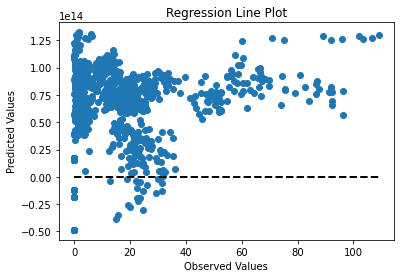

In [39]:
# Plot observed values vs. predicted values
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Regression Line Plot')
plt.show()

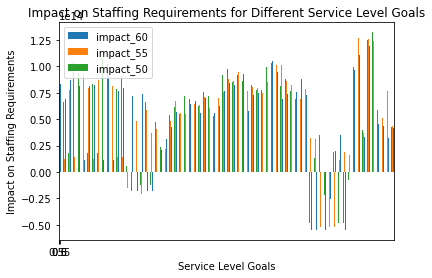

In [40]:
# Create a list of service level goals
service_levels = [0.6, 0.55, 0.5]

# Plot bar plot
df_impacts.plot(kind='bar')
plt.xticks(np.arange(len(service_levels)), service_levels, rotation='horizontal')
plt.xlabel('Service Level Goals')
plt.ylabel('Impact on Staffing Requirements')
plt.title('Impact on Staffing Requirements for Different Service Level Goals')
plt.legend(loc='upper left')
plt.show()

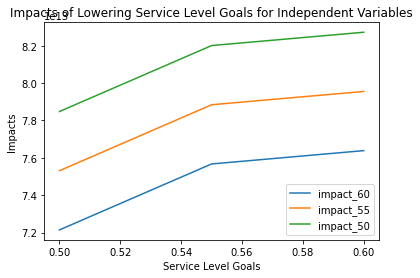

In [41]:
# Create a new DataFrame for the line plot
line_plot_data = pd.DataFrame({'Service Level Goal': service_levels})

# Add the impact values for each independent variable to the DataFrame
for i, column_name in enumerate(df_impacts.columns[:-1]):
    line_plot_data[column_name] = df_impacts[column_name]

# Add the missing column "impact_50" to the DataFrame
line_plot_data['impact_50'] = df_impacts['impact_50']

# Plot line plot
for column_name in line_plot_data.columns[1:]:
    plt.plot(line_plot_data['Service Level Goal'], line_plot_data[column_name], label=column_name)

plt.xlabel('Service Level Goals')
plt.ylabel('Impacts')
plt.title('Impacts of Lowering Service Level Goals for Independent Variables')
plt.legend()
plt.show()
